# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Comparison-with-other-transcriptomic-phenotypes" data-toc-modified-id="Comparison-with-other-transcriptomic-phenotypes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparison with other transcriptomic phenotypes</a></div><div class="lev2 toc-item"><a href="#Hypoxia-Response" data-toc-modified-id="Hypoxia-Response-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Hypoxia Response</a></div><div class="lev2 toc-item"><a href="#Dpy-Response" data-toc-modified-id="Dpy-Response-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dpy Response</a></div><div class="lev2 toc-item"><a href="#The-RAS-pathway" data-toc-modified-id="The-RAS-pathway-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>The RAS pathway</a></div><div class="lev1 toc-item"><a href="#Ras-GF" data-toc-modified-id="Ras-GF-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ras GF</a></div><div class="lev2 toc-item"><a href="#The-WNT-Pathway" data-toc-modified-id="The-WNT-Pathway-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The WNT Pathway</a></div>

In [1]:
import pandas as pd
import numpy as np
import scipy as scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import tissue_enrichment_analysis as tea
import bokeh

from scipy import stats

import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
tidy  = pd.read_csv('../output/dpy_22_results.csv')
mediator = pd.read_csv('../input/complexes.csv')

In [3]:
tissue = tea.fetch_dictionary('tissue')
phenotype = tea.fetch_dictionary('phenotype')
go = tea.fetch_dictionary('go')

In [4]:
def melt(df):
    """A melt function for the tea dictionaries."""
    expression = pd.melt(df, id_vars='wbid', var_name='term')
    expression = expression[expression.value == 1]
    return expression[['wbid', 'term']]

expression = melt(tissue)
phenom = melt(phenotype)
gom = melt(go)

In [5]:
def get_melted_dictionary(kind='tissue'):
    if kind not in ['phenotype', 'go', 'tissue']:
        raise ValueError('dictionary must be one of `dictionary`, `go` or `tissue`.')
    if kind is 'tissue':
        temp = tissue
    elif kind is 'phenotype':
        temp = phenotype
    else:
        temp = go
    df = melt(temp)
    return df


def extract_term_ids(term, df, q=0.1, cond=True):
    terms = df[df.term.str.lower().str.contains(term.lower())].term.unique()
    if len(terms) > 1:
        print('Warning, more than 1 term was pulled out of the dictionary.')
        print(df[df.term.str.lower().str.contains(term.lower())].term.unique())

    ids = df[df.term.str.lower().str.contains(term.lower())].wbid
    if len(ids) == 0:
        raise ValueError('No genes found with term {0}.'.format(term))

    data = tidy[(tidy.qval < q) & (tidy.ens_gene.isin(ids)) & cond]
    return ids, data, terms
    

def plot_by_term(term, dictionary, q=0.1, x='b', y='genotype', **kwargs):
    jitter = kwargs.pop('jitter', True)
    cond = kwargs.pop('cond', True)
    df = get_melted_dictionary(kind=dictionary)
    ids, data, terms = extract_term_ids(term, df, q=0.1)

    if len(ids) == 0:
        raise ValueError('No genes found with this term.')
    
    data = tidy[(tidy.qval < q) & (tidy.ens_gene.isin(ids)) & cond]
    if len(data) < 150:
        sns.stripplot(x=x, y=y, data=data, jitter=jitter, **kwargs)
    else:
        sns.boxplot(x=x, y=y, data=data, **kwargs)
    plt.axvline(0, color='red', ls='--', lw=1)
    
    if len(terms) == 1:
        plt.title(terms[0])
    
    return plt.gca(), ids

In [6]:
def ea(dictionary=tissue, q=0.001, filter_level=1):
    results = {}
    for name, group in tidy.groupby('phenotypic class'):
        wbids = group.ens_gene.unique()
        df = tea.enrichment_analysis(wbids, dictionary, show=False, alpha=q)
        results[name] = df[df['Enrichment Fold Change'] > filter_level]
    return results

def print_ea(results, n=25):
    for key, value in results.items():
        print(key)
        if len(value) > 0:
            print(value[['Tissue', 'Q value']].head(n))
        else: 
            print('No results')
        print('\n\n\n')

In [7]:
tissue_results = ea(tissue)
print_ea(tissue_results)

sy622 specific
                                 Tissue       Q value
36               intestine WBbt:0005772  2.777039e-13
145  anal depressor muscle WBbt:0004292  1.241746e-06
194        muscular system WBbt:0005737  3.005509e-06
37               sex organ WBbt:0008422  1.065684e-04
245     lateral nerve cord WBbt:0006769  6.131558e-04




transhet specific
                               Tissue       Q value
239                 male WBbt:0007850  4.463500e-50
235  reproductive system WBbt:0005747  5.610937e-21




bx93 associated
                                Tissue       Q value
42              intestine WBbt:0005772  1.370626e-07
100  cephalic sheath cell WBbt:0008406  2.529487e-04
82      epithelial system WBbt:0005730  5.970343e-04




bx93 specific
No results




sy622 associated
                               Tissue       Q value
32             intestine WBbt:0005772  4.810282e-07
28  cephalic sheath cell WBbt:0008406  2.195023e-04






In [8]:
phenotype_results = ea(phenotype)
print_ea(phenotype_results)

sy622 specific
                                                Tissue       Q value
181          avoids bacterial lawn WBPhenotype:0000402  2.879120e-10
202              gonad vesiculated WBPhenotype:0001979  3.524123e-09
207  pleiotropic defects severe early emb WBPhenoty...  2.342550e-08
194                  rachis narrow WBPhenotype:0001941  2.985135e-05
161  transgene expression increased WBPhenotype:000...  6.344530e-05
48   germ cell compartment anucleate WBPhenotype:00...  2.543166e-04
140           oocytes lack nucleus WBPhenotype:0001956  3.108577e-04
73   pachytene progression during oogenesis variant...  7.753719e-04




transhet specific
No results




bx93 associated
No results




bx93 specific
No results




sy622 associated
No results






In [9]:
go_results = ea(go, filter_level=2)
print_ea(go_results, n=50)

sy622 specific
                                                Tissue        Q value
65                    developmental process GO:0032502  3.086868e-170
218                      embryo development GO:0009790  1.067431e-141
18                             reproduction GO:0000003  6.251741e-122
46               post-embryonic development GO:0009791  1.970665e-121
56                                    aging GO:0007568   2.327986e-68
197         reproductive system development GO:0061458   1.424288e-43
20   development of primary sexual characteristics ...   4.387607e-43
286                           mitochondrion GO:0005739   8.859881e-42
282           multicellular organism growth GO:0035264   2.874981e-22
176           positive regulation of growth GO:0045927   2.993624e-22
3                                cell death GO:0008219   7.392770e-21
223                    localization of cell GO:0051674   8.688423e-20
140                 muscle cell development GO:0055001   4.062029e-19
21   

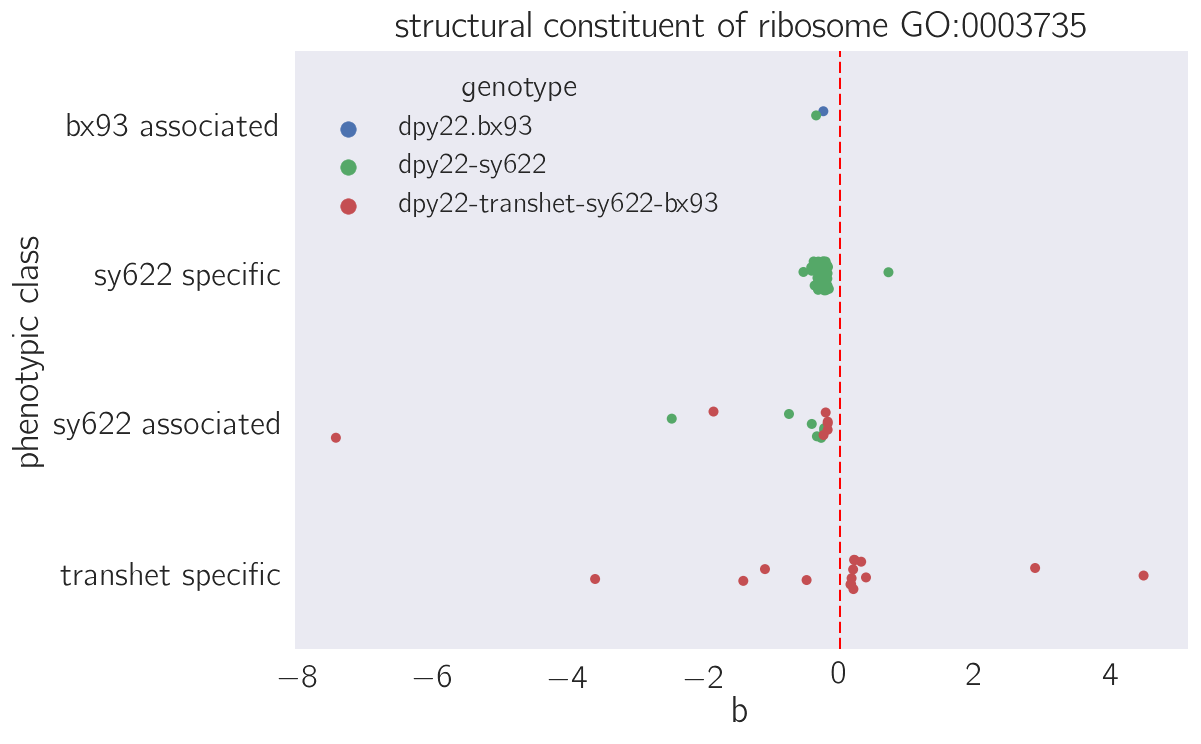

In [10]:
ax, ids = plot_by_term('ribosome', 'go', y='phenotypic class', hue='genotype')

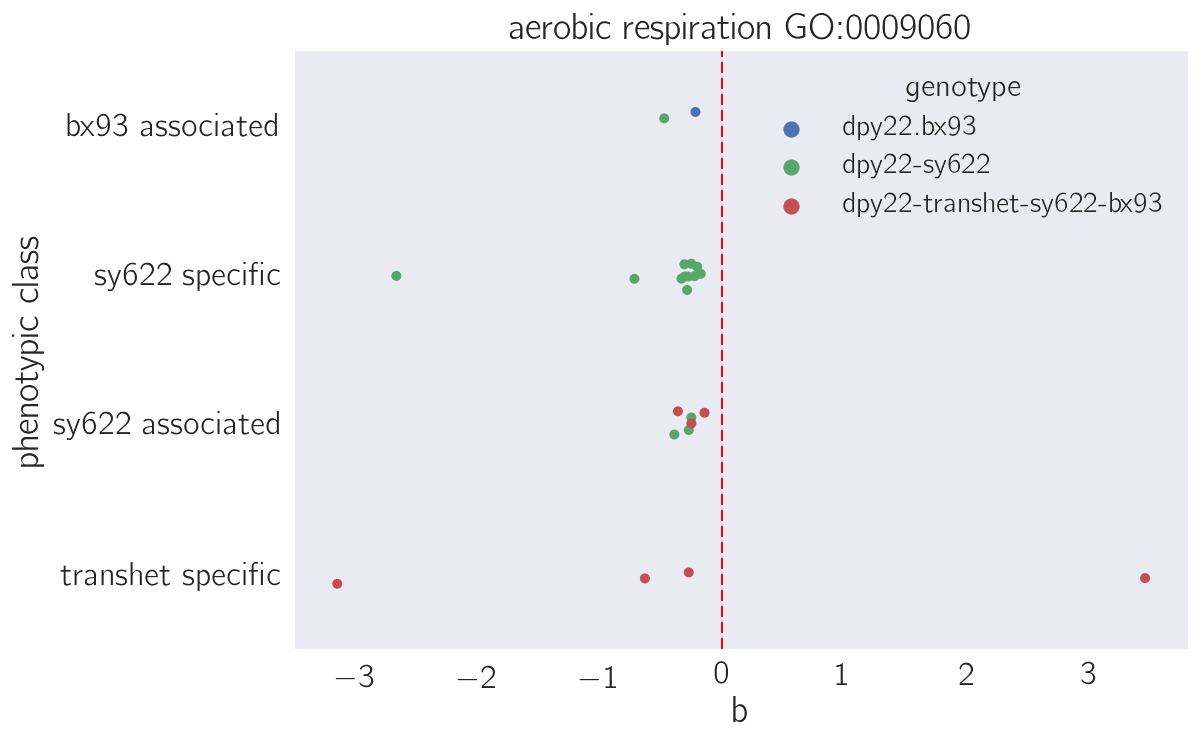

In [11]:
ax, ids = plot_by_term('respiration', 'go', y='phenotypic class', hue='genotype')

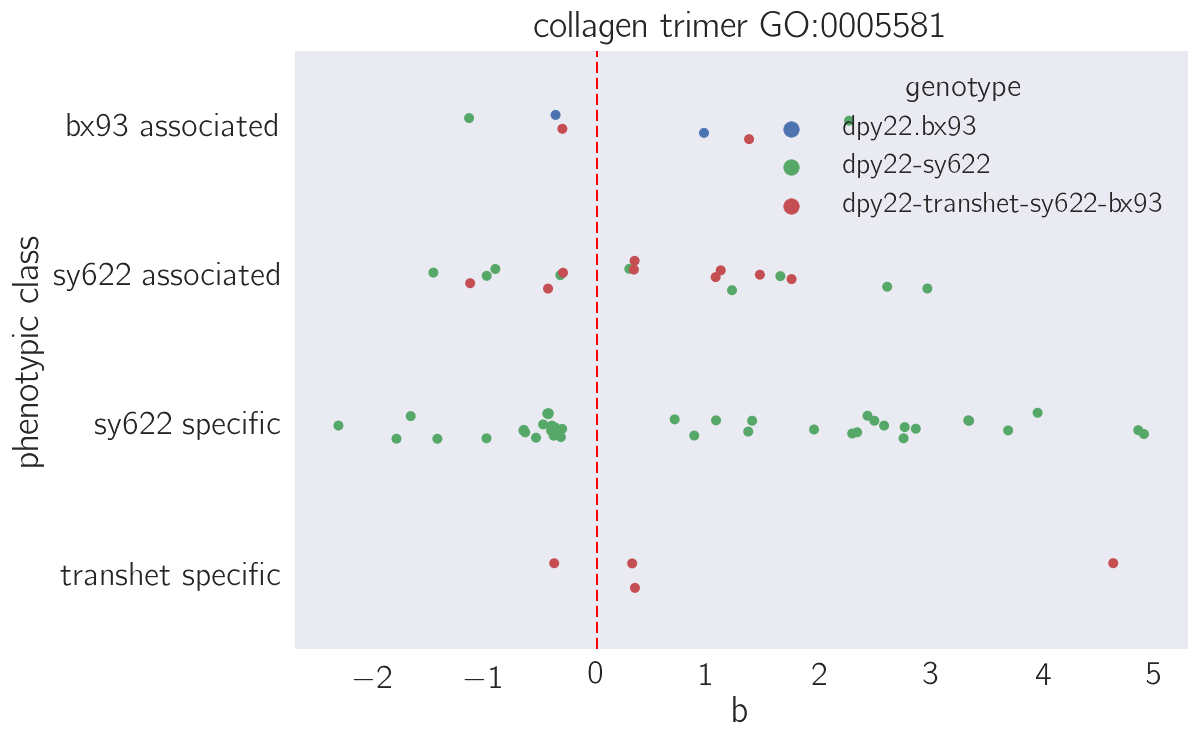

In [12]:
ax, ids = plot_by_term('collagen trimer', 'go', y='phenotypic class', hue='genotype')

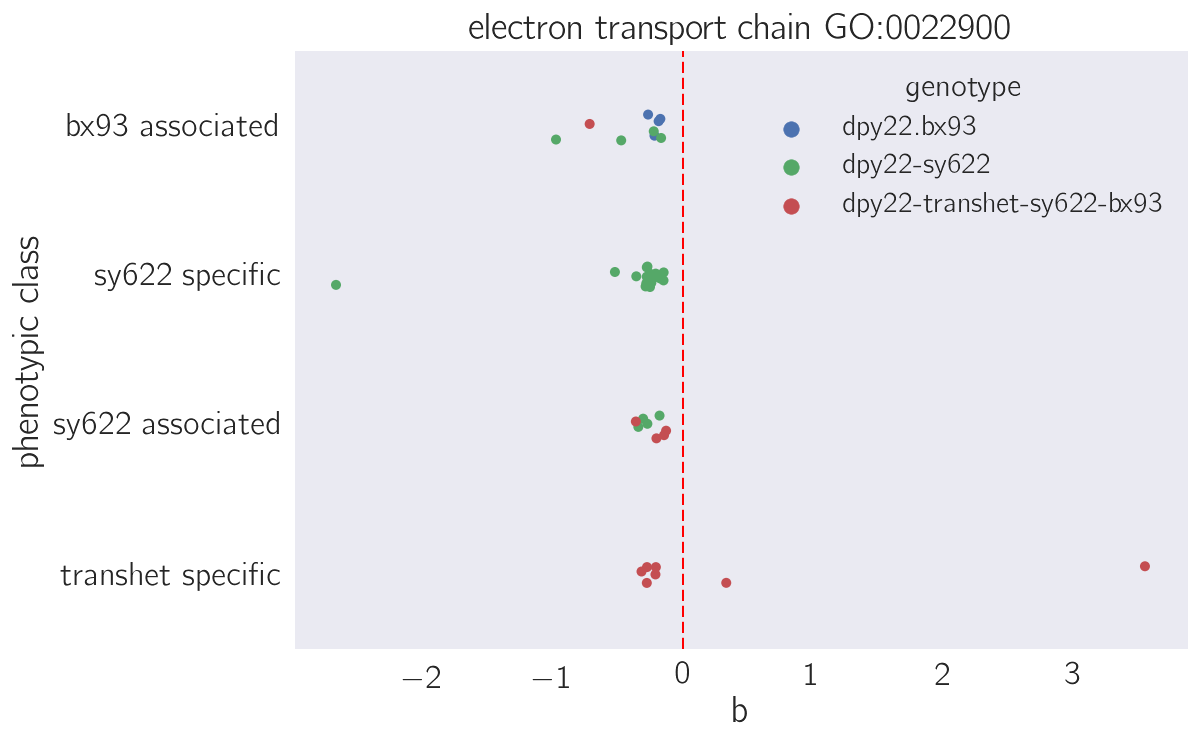

In [13]:
 ax, ids = plot_by_term('electron transport chain', 'go', y='phenotypic class', hue='genotype')

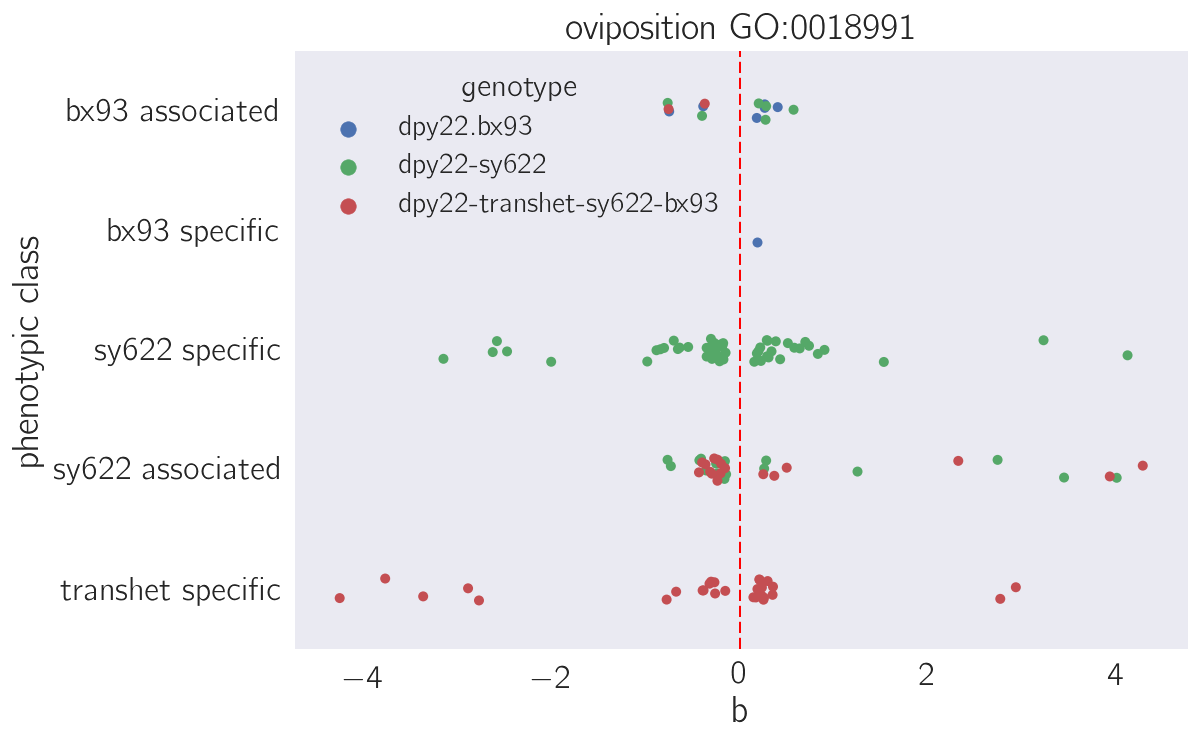

In [14]:
ax, ids = plot_by_term('oviposition', 'go', y='phenotypic class', hue='genotype')

# Comparison with other transcriptomic phenotypes

In [15]:
hypoxia = pd.read_csv('../input/hypoxia_response.csv')
dpy = pd.read_csv('../input/dpy_geneset.csv')

In [16]:
# hypergeometric test
def test_classes_hgf(dataset, alpha=10**-6, q=0.1):
    """
    Performs enrichment analysis of each phenotypic class using a provided background dataset.
    
    This function performs a hypergeometric enrichment analysis of each phenotypic class
    compared with a provided background dataset. The results are adjusted for FDR using a 
    conservative Bonferroni correction. 
    
    dataset --- a pandas dataframe. Must contain column `target_id'
    alpha --- statistical significance threshold before Bonferroni
    
    Output:
    None --- prints results to screen
    """
    bonferroni = len(tidy['phenotypic class'].unique())
    for name, group in tidy[(tidy.qval < q)].groupby('phenotypic class'):
        found = group[(group.target_id.isin(dataset.target_id))].target_id.unique()
        pval = stats.hypergeom.sf(len(found), len(tidy.target_id.unique()), len(dataset), len(group))
        expected = stats.hypergeom.mean(len(tidy.target_id.unique()), len(dataset), len(group))
        print(name, '{0:.2g}% found'.format(100*len(found)/len(dataset)))
        if pval < alpha/bonferroni:
            print('This overlap is significant, pval {0:.2g}, FC={1:.2g}, obs={2}'.format(pval, len(found)/expected, len(found)))

# spearman
def spearman(dataset, alpha=10**-3, min_frac=0.1, q=0.1):
    """
    Performs Mann Whitney U tests of each genotype using a provided background dataset.
    
    This function performs a Mann Whitney U test on each genotype to compare whether the
    distribution of effects is the same as the provided dataset.
    
    dataset --- a pandas dataframe. Must contain column `target_id'
    alpha --- statistical significance threshold before Bonferroni
    min_frac --- minimum fraction of the dataset that must be found in the test set to
                 test for significance. Defaults to 10%

    Output:
    None --- prints results to screen
    """
    bonferroni = len(tidy.genotype.unique())
    for name, group in tidy[(tidy.qval < q)].groupby('genotype'):
        found = group[(group.target_id.isin(dataset.target_id))]
        print(name, '{0:.2g}% found'.format(100*len(found)/len(dataset)))
        if (len(found) < min_frac*len(dataset)) & (len(found) < min_frac*len(group)):
            continue
        mwu = stats.mannwhitneyu(found.b, dataset.b)
        spearman = stats.spearmanr(found.b, dataset[dataset.target_id.isin(found.target_id)].b)
        if spearman.pvalue < alpha/bonferroni:
            print('The two responses are correlated with corr={0:.2g}, p={1:.2g}'.format(spearman.correlation, spearman.pvalue).upper())
        else:
            print('The two responses are NOT correlated, , p={0:.2g}'.format(spearman.pvalue))
        
def plot_response(dataset, genotype='dpy22-sy622', q=0.1):
    """Given a dataset, plot the genes that are DE in the specified genotype against the dataset values."""
    x = tidy[(tidy.target_id.isin(dataset.target_id)) & (tidy.qval < q) & (tidy.genotype == genotype)].copy()
    y = dataset[dataset.target_id.isin(x.target_id)].copy()
    plt.plot(x.b, y.b, 'o', ms=3)
    plt.xlabel(genotype)

## Hypoxia Response

In [17]:
print('test hypoxia dataset for enrichment')
test_classes_hgf(hypoxia)

test hypoxia dataset for enrichment
bx93 associated 10% found
This overlap is significant, pval 9.9e-09, FC=2.1, obs=63
bx93 specific 0.8% found
sy622 associated 13% found
This overlap is significant, pval 4.4e-08, FC=1.9, obs=78
sy622 specific 30% found
This overlap is significant, pval 8.8e-55, FC=3.4, obs=186
transhet specific 5% found


In [18]:
print('spearman analysis of hypoxia response')
spearman(hypoxia)

spearman analysis of hypoxia response
dpy22-sy622 51% found
The two responses are NOT correlated, , p=0.63
dpy22-transhet-sy622-bx93 26% found
The two responses are NOT correlated, , p=0.48
dpy22.bx93 11% found
The two responses are NOT correlated, , p=0.96


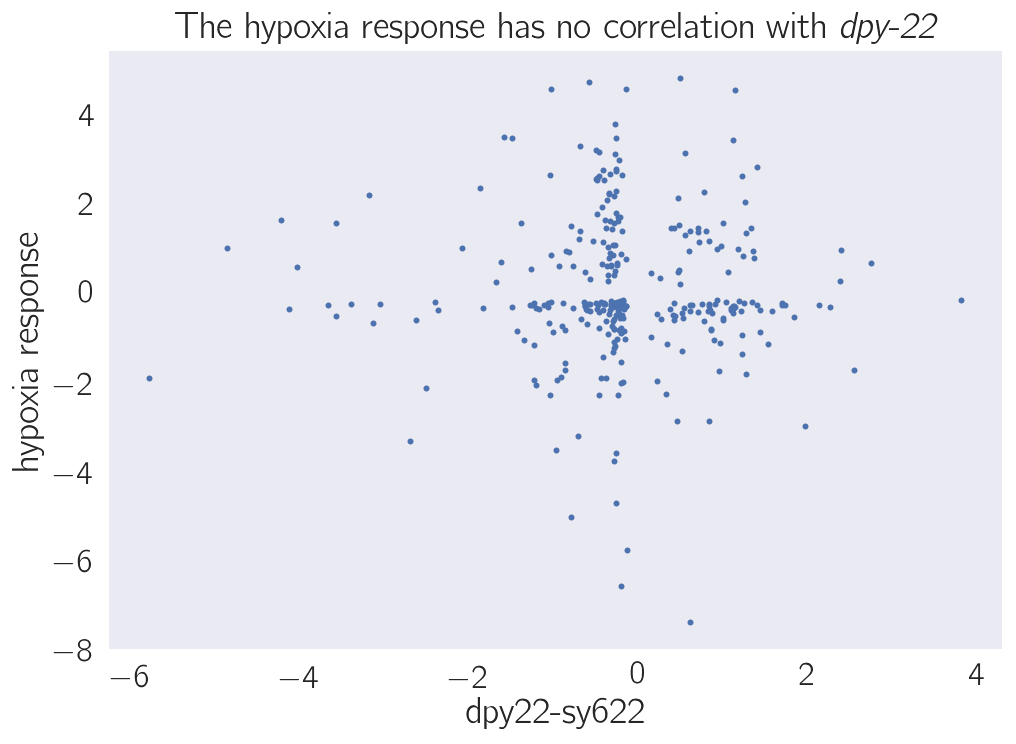

In [19]:
plot_response(hypoxia)
plt.ylabel('hypoxia response')
plt.title('The hypoxia response has no correlation with \emph{dpy-22}')

## Dpy Response

In [20]:
print('testing the Dpy dataset')
test_classes_hgf(dpy)

testing the Dpy dataset
bx93 associated 11% found
This overlap is significant, pval 4.1e-10, FC=2.2, obs=68
bx93 specific 1.4% found
sy622 associated 13% found
This overlap is significant, pval 8.8e-09, FC=1.9, obs=82
sy622 specific 26% found
This overlap is significant, pval 2.3e-40, FC=3, obs=167
transhet specific 6.8% found


In [21]:
print('spearman analysis of Dpy response')
spearman(dpy)

spearman analysis of Dpy response
dpy22-sy622 48% found
THE TWO RESPONSES ARE CORRELATED WITH CORR=0.42, P=5.7E-15
dpy22-transhet-sy622-bx93 28% found
The two responses are NOT correlated, , p=0.011
dpy22.bx93 12% found
The two responses are NOT correlated, , p=0.71


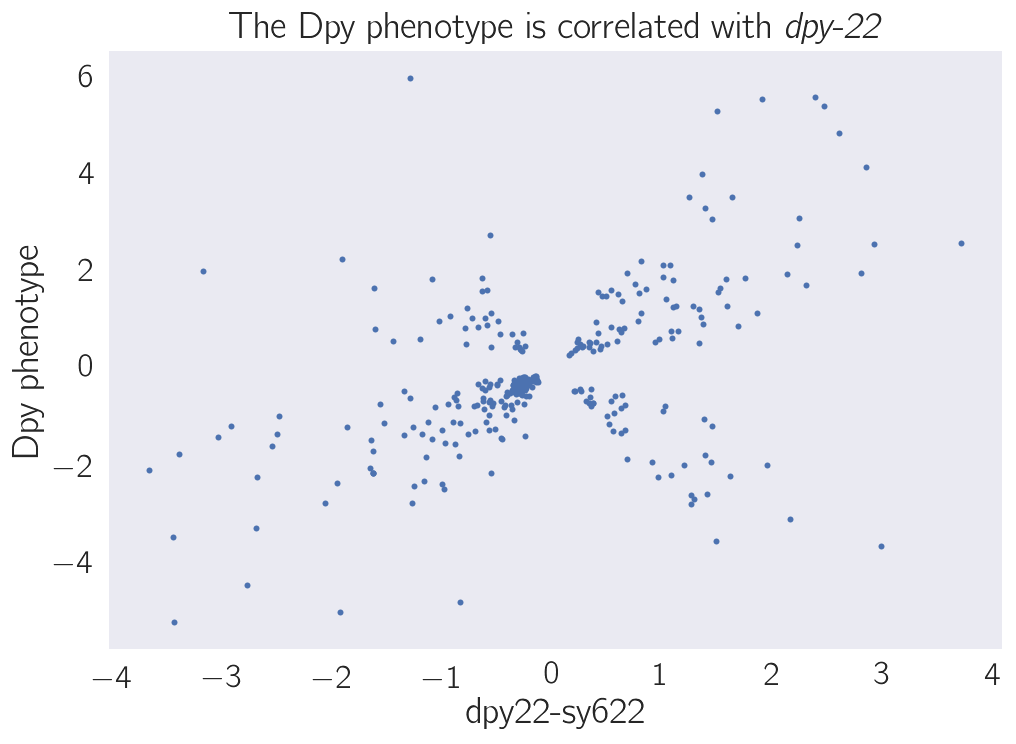

In [22]:
plot_response(dpy)
plt.ylabel('Dpy phenotype')
plt.title('The Dpy phenotype is correlated with \emph{dpy-22}')

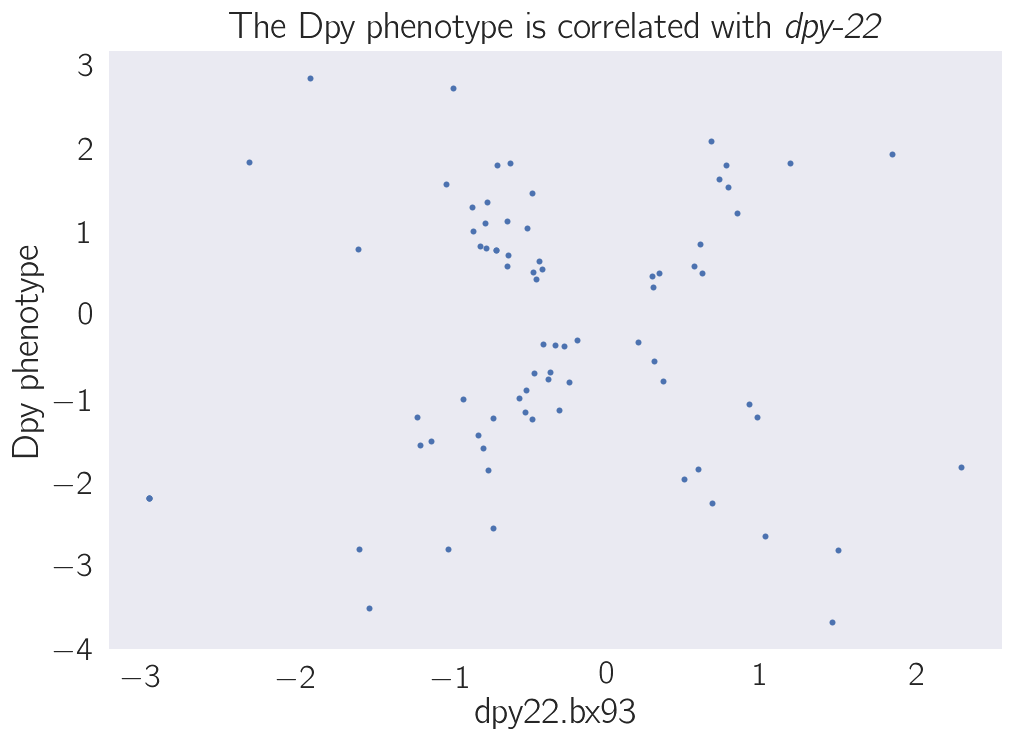

In [41]:
plot_response(dpy, genotype='dpy22.bx93')
plt.ylabel('Dpy phenotype')
plt.title('The Dpy phenotype is correlated with \emph{dpy-22}')

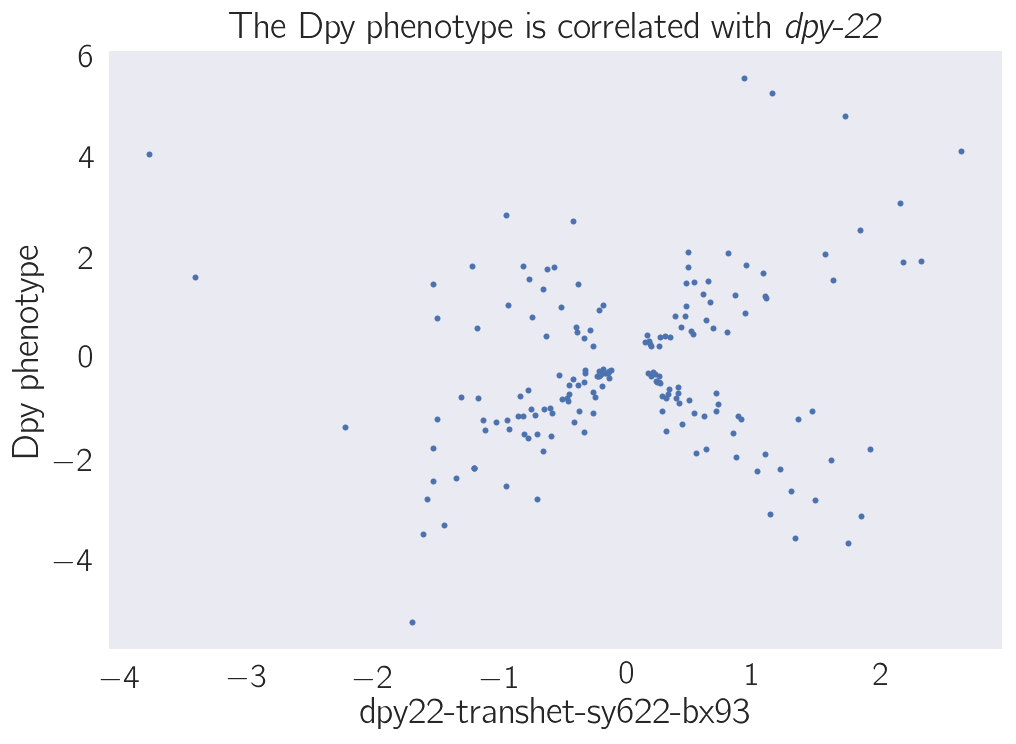

In [23]:
plot_response(dpy, genotype='dpy22-transhet-sy622-bx93')
plt.ylabel('Dpy phenotype')
plt.title('The Dpy phenotype is correlated with \emph{dpy-22}')

In [24]:
x = tidy[(tidy.genotype == 'dpy22-sy622') & (tidy.qval < q) & (tidy.target_id.isin(dpy.target_id))].copy()
y = dpy[dpy.target_id.isin(x.target_id)].copy()
y.sort_values('target_id', inplace=True)
x.sort_values('target_id', inplace=True)
y['b_sy622'] = x.b.values

In [25]:
dpy_response = y[y.b*y.b_sy622 > 0]
nondpy_response = y[y.b*y.b_sy622 < 0]
print(len(dpy_response))
print(len(nondpy_response))

233
76


In [42]:
s = stats.spearmanr(dpy_response.sort_values('target_id').b, dpy_response.sort_values('target_id').b_sy622)
s

SpearmanrResult(correlation=0.93823297820869189, pvalue=1.88315112573268e-108)

## The RAS pathway

In [58]:
ras = pd.read_csv('../input/ras_geneset.csv')

In [59]:
print('test ras dataset for enrichment')
test_classes_hgf(ras)

test ras dataset for enrichment
bx93 associated 13% found
bx93 specific 0.52% found
sy622 associated 25% found
This overlap is significant, pval 6e-17, FC=3.8, obs=49
sy622 specific 15% found
transhet specific 11% found


In [60]:
print('spearman analysis of Ras response')
spearman(ras)

spearman analysis of Ras response
dpy22-sy622 53% found
THE TWO RESPONSES ARE CORRELATED WITH CORR=0.83, P=7.1E-27
dpy22-transhet-sy622-bx93 48% found
THE TWO RESPONSES ARE CORRELATED WITH CORR=0.92, P=3.9E-39
dpy22.bx93 14% found
THE TWO RESPONSES ARE CORRELATED WITH CORR=0.88, P=9.2E-10


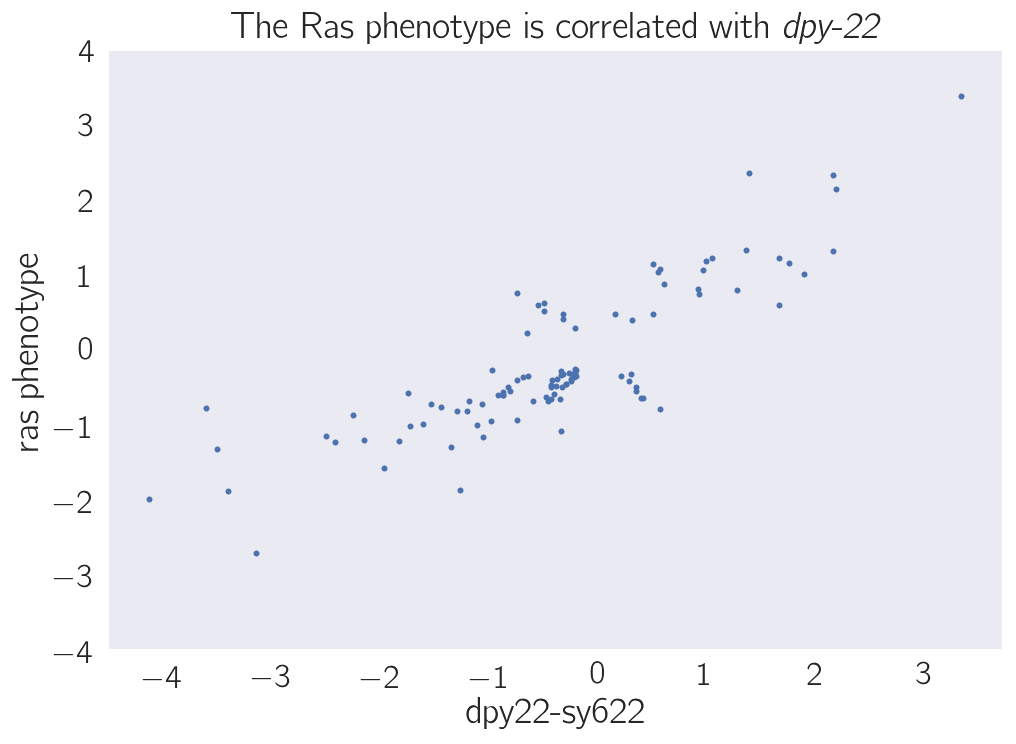

In [61]:
plot_response(ras)
plt.ylabel('ras phenotype')
plt.ylim(-4, 4)
plt.title('The Ras phenotype is correlated with \emph{dpy-22}')

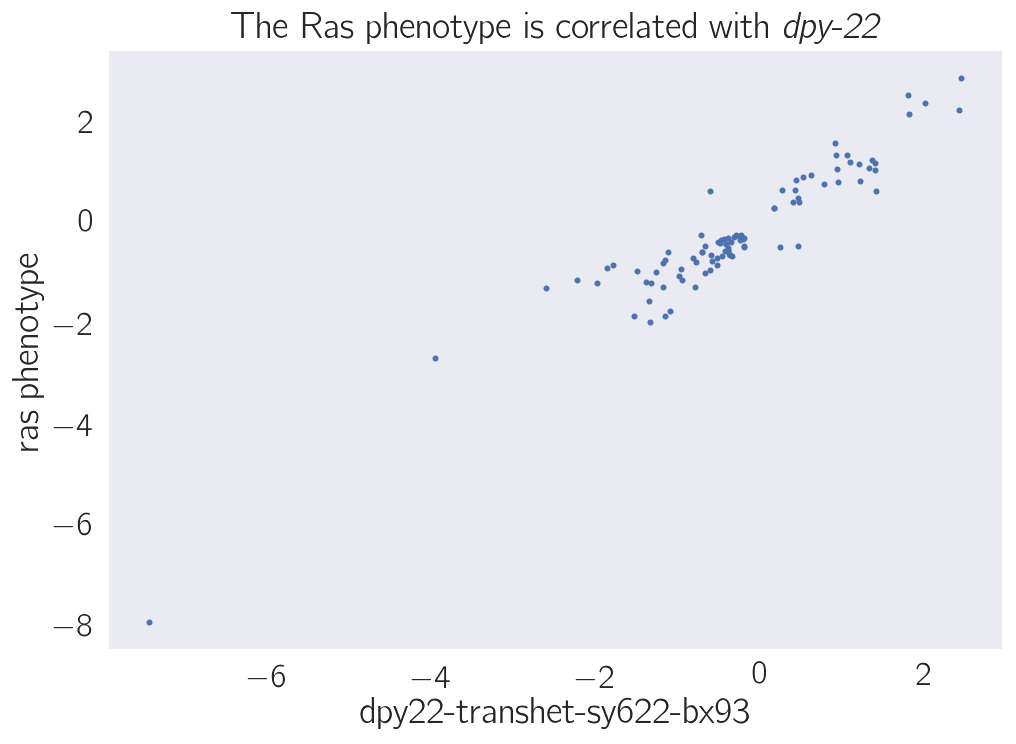

In [62]:
plot_response(ras, genotype='dpy22-transhet-sy622-bx93')
plt.ylabel('ras phenotype')
# plt.ylim(-4, 4)
plt.title('The Ras phenotype is correlated with \emph{dpy-22}')

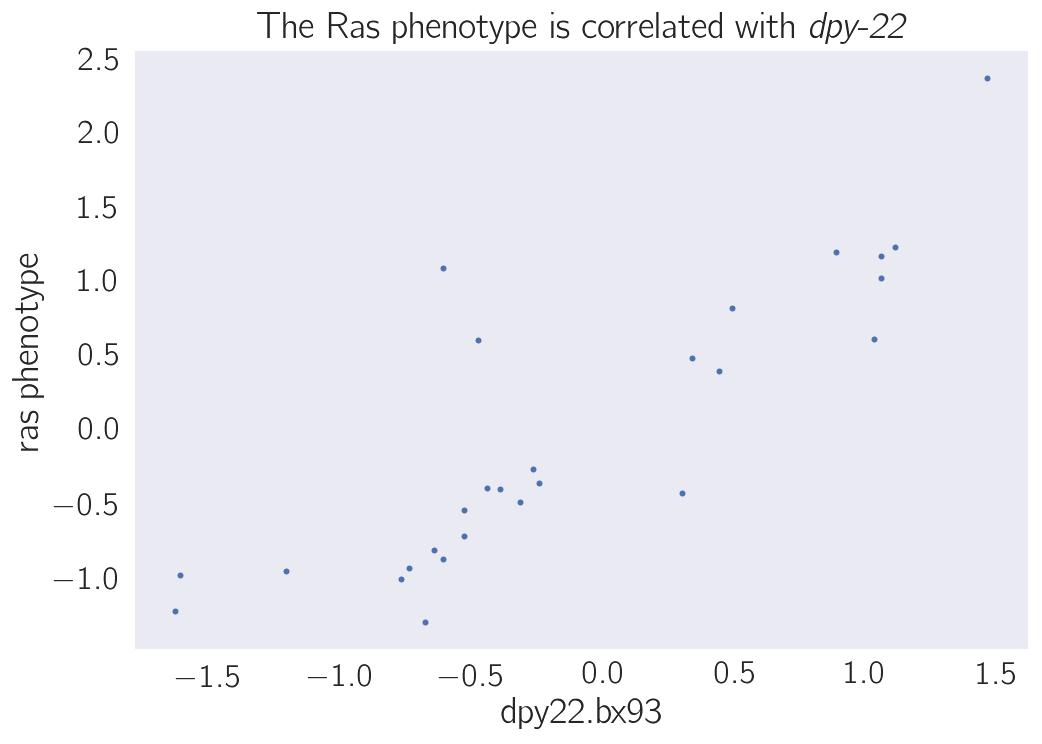

In [63]:
plot_response(ras, genotype='dpy22.bx93')
plt.ylabel('ras phenotype')
# plt.ylim(-4, 4)
plt.title('The Ras phenotype is correlated with \emph{dpy-22}')

# Ras GF

In [64]:
rasgf = pd.read_csv('../input/rasgf_geneset.csv')

In [65]:
print('test ras(gf) dataset for enrichment')
test_classes_hgf(rasgf)

print('\n\n----------\n\nspearman analysis of Ras(gf) response')
spearman(rasgf)

test ras(gf) dataset for enrichment
bx93 associated 4.8% found
bx93 specific 0.55% found
sy622 associated 8.2% found
sy622 specific 7.3% found
transhet specific 22% found
This overlap is significant, pval 3.7e-158, FC=3.9, obs=443


----------

spearman analysis of Ras(gf) response
dpy22-sy622 19% found
THE TWO RESPONSES ARE CORRELATED WITH CORR=0.82, P=3.1E-94
dpy22-transhet-sy622-bx93 34% found
THE TWO RESPONSES ARE CORRELATED WITH CORR=0.86, P=4.7E-196
dpy22.bx93 5.4% found
THE TWO RESPONSES ARE CORRELATED WITH CORR=0.82, P=3.3E-27


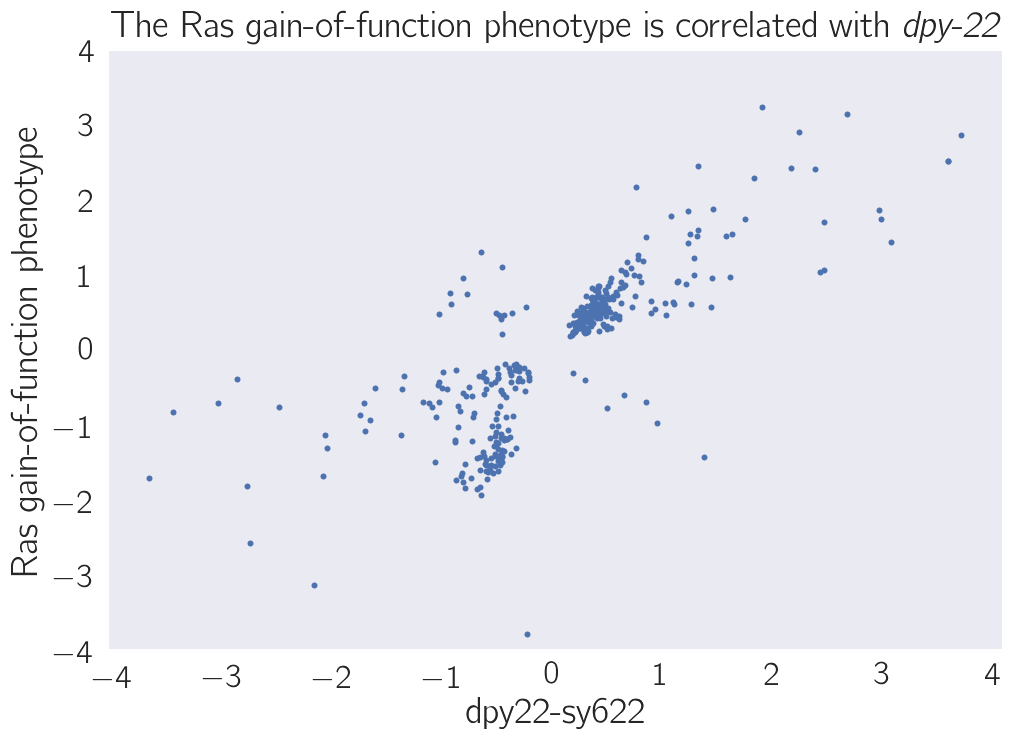

In [66]:
plot_response(rasgf)
plt.ylabel('Ras gain-of-function phenotype')
plt.ylim(-4, 4)
plt.title('The Ras gain-of-function phenotype is correlated with \emph{dpy-22}')

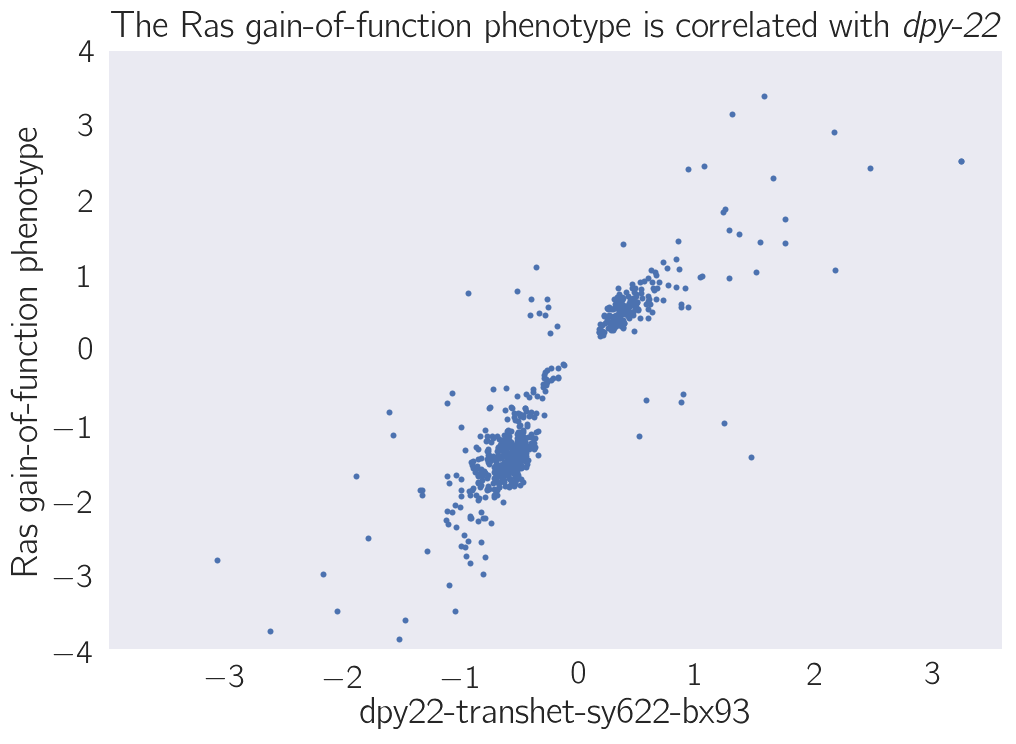

In [67]:
plot_response(rasgf, genotype='dpy22-transhet-sy622-bx93')
plt.ylabel('Ras gain-of-function phenotype')
plt.ylim(-4, 4)
plt.title('The Ras gain-of-function phenotype is correlated with \emph{dpy-22}')

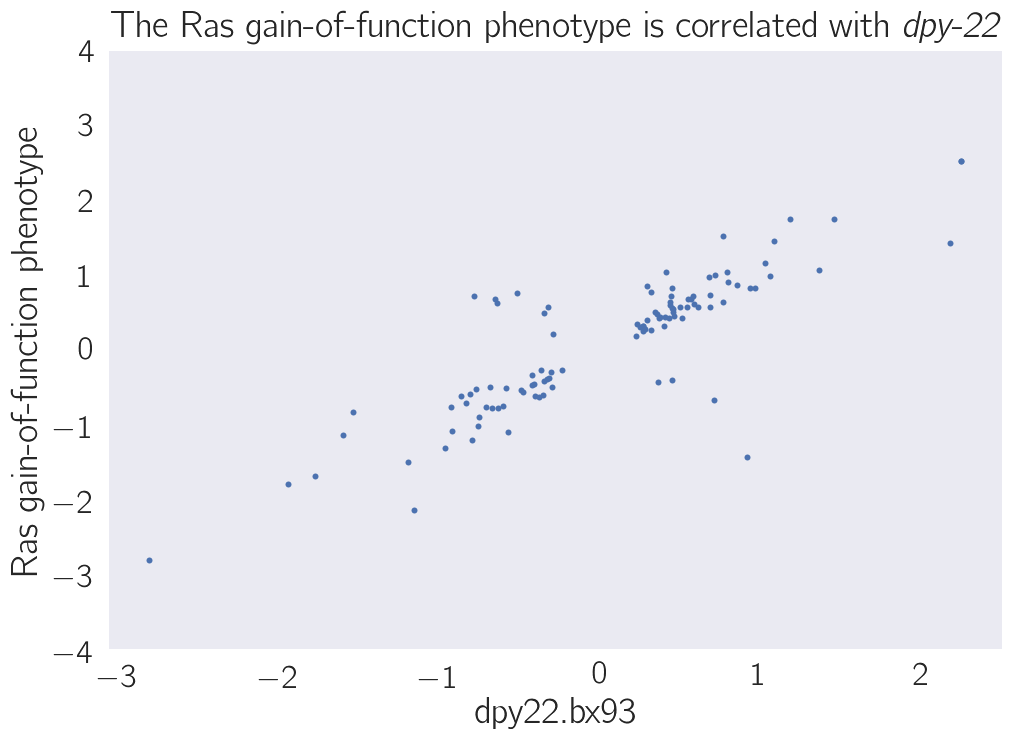

In [68]:
plot_response(rasgf, genotype='dpy22.bx93')
plt.ylabel('Ras gain-of-function phenotype')
plt.ylim(-4, 4)
plt.title('The Ras gain-of-function phenotype is correlated with \emph{dpy-22}')

## The WNT Pathway

In [69]:
wnt = pd.read_csv('../input/wnt_geneset.csv')

In [36]:
print('test wnt dataset for enrichment')
test_classes_hgf(wnt)

test wnt dataset for enrichment
bx93 associated 6.7% found
This overlap is significant, pval 7.8e-09, FC=1.4, obs=243
bx93 specific 0.55% found
sy622 associated 11% found
This overlap is significant, pval 1.1e-25, FC=1.6, obs=396
sy622 specific 20% found
This overlap is significant, pval 6.1e-128, FC=2.3, obs=726
transhet specific 14% found
This overlap is significant, pval 4.7e-106, FC=2.5, obs=523


In [37]:
print('spearman analysis of Wnt response')
spearman(wnt)

spearman analysis of Wnt response
dpy22-sy622 37% found
THE TWO RESPONSES ARE CORRELATED WITH CORR=0.81, P=4.7E-315
dpy22-transhet-sy622-bx93 30% found
THE TWO RESPONSES ARE CORRELATED WITH CORR=0.78, P=5.5E-227
dpy22.bx93 7.3% found
THE TWO RESPONSES ARE CORRELATED WITH CORR=0.73, P=8.2E-45


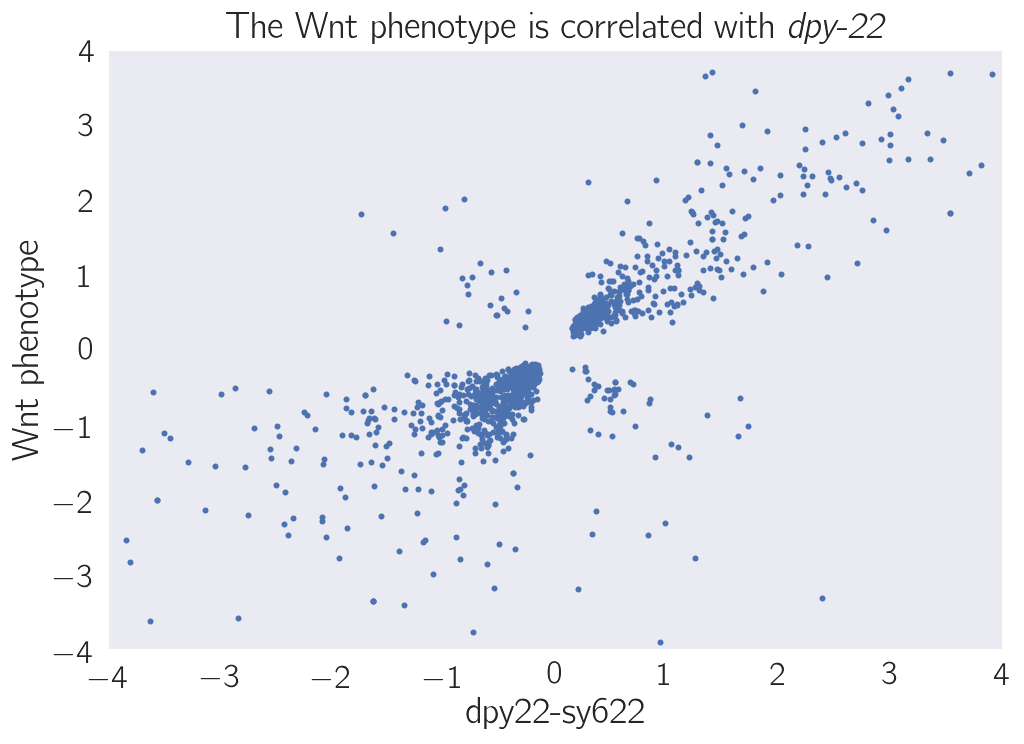

In [40]:
plot_response(wnt, genotype='dpy22-sy622')

plt.xlim(-4, 4)
plt.ylim(-4, 4)

plt.ylabel('Wnt phenotype')
plt.title('The Wnt phenotype is correlated with \emph{dpy-22}')

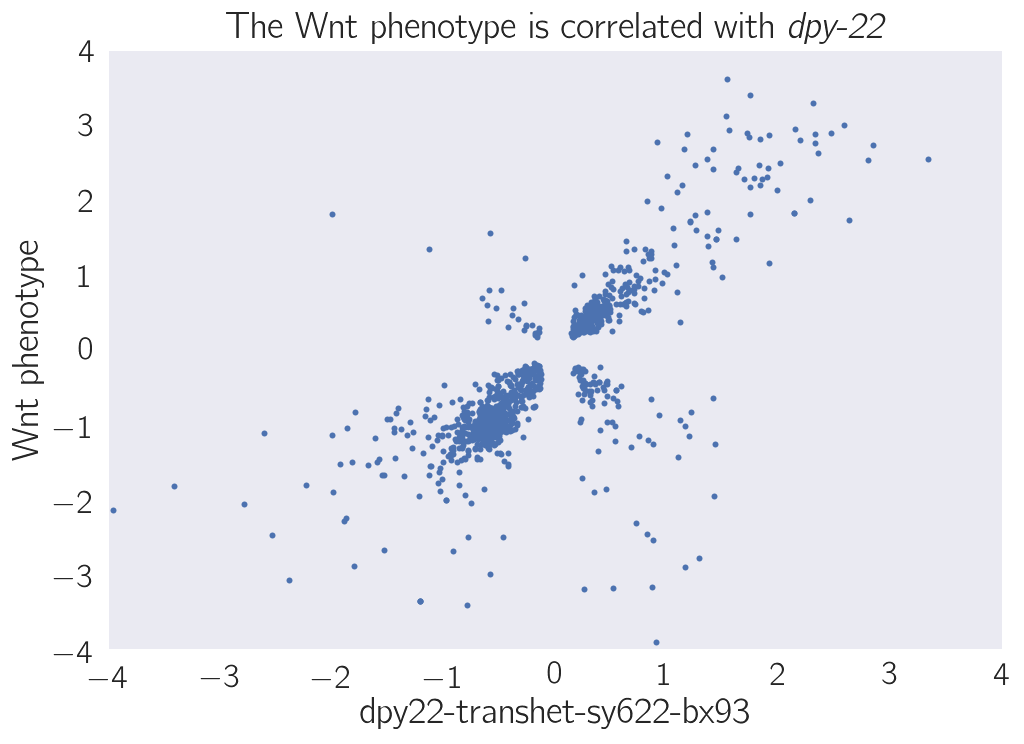

In [43]:
plot_response(wnt, genotype='dpy22-transhet-sy622-bx93')

plt.xlim(-4, 4)
plt.ylim(-4, 4)

plt.ylabel('Wnt phenotype')
plt.title('The Wnt phenotype is correlated with \emph{dpy-22}')